# Machine Learning Group Project

Amal Babu, Dheeraj Kashyap, Rohil Verma, Yash Sharma

In [10]:
# Import headers
import random
import math
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

### Data Preprocessing Stage

First, we get our data and do some processing. We have a lot of columns, 80 features
per row. Many of these features are categorical, so we convert them into a combination
of ordinal and one hot encoded features. This makes it such that our data is more 
compatible with algorithms such as linear regression, clustering and SVMS. We also
convert the NA's to -1. We choose -1 so that it won't interfere with our ordinal values
and will thus be treated as a value of its own.

In [11]:
# One-hot encoding all the categorical features in the dataset
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest


data = pd.read_csv('train.csv')

label = data['SalePrice']
data = data.loc[:, data.columns != 'SalePrice']

data.fillna(-1, inplace=True)

categorical = ['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',  'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'CentralAir', 'Electrical', 'Functional', 'GarageType', 'GarageFinish', 'PavedDrive', 'MiscFeature', 'SaleType', 'SaleCondition']

data['LotFrontage'] = pd.to_numeric(data['LotFrontage'], errors='coerce').fillna(0).astype(float)

encoder = OneHotEncoder()

encoded_data = pd.get_dummies(data, columns = categorical)
encoded_data.head()

# Changing all ordinal variables into numbers based on ranking
rank_mapping = {
    'Ex': 5,
    'Gd': 4,
    'TA': 3,
    'Fa': 2,
    'Po': 1,
    'NA': 0
}

ranked_columns = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC']

for column in ranked_columns:
    encoded_data[column] = encoded_data[column].replace(rank_mapping)

print(encoded_data.head())

   Id  LotFrontage  LotArea  OverallQual  OverallCond  YearBuilt  \
0   1         65.0     8450            7            5       2003   
1   2         80.0     9600            6            8       1976   
2   3         68.0    11250            7            5       2001   
3   4         60.0     9550            7            5       1915   
4   5         84.0    14260            8            5       2000   

   YearRemodAdd  MasVnrArea  ExterQual  ExterCond  ...  SaleType_ConLw  \
0          2003       196.0          4          3  ...               0   
1          1976         0.0          3          3  ...               0   
2          2002       162.0          4          3  ...               0   
3          1970         0.0          3          3  ...               0   
4          2000       350.0          4          3  ...               0   

   SaleType_New SaleType_Oth  SaleType_WD  SaleCondition_Abnorml  \
0             0            0            1                      0   
1         

### Feature Selection
Next, we try to figure out which features show the most correlation with the target
feature, SalePrice. As we said earlier, we have 80 features per row, and it can be
helpful for us to narrow down the number of rows to avoid noise in the data for 
the future. the most related feature seems to be Overall Quality, followed by Living Area square feet. While these features make sense, it is interesting how other variables such
as overall condition, which you would expect to be influential, does not fall into the
top corralations.

In [12]:
# Creating a correlation matrix to find strong correlation between different
# features and the house price
matrix = encoded_data.corrwith(label, numeric_only=True)

# Selecting columns with a correlation greater than the threshold
thresh = 0.5
filtered_matrix = matrix[abs(matrix) > thresh].sort_values(ascending = False)
filtered_matrix = filtered_matrix.to_frame().transpose()
print(filtered_matrix)

# Creating another dataframe with only the highly correlated features
filtered_data = encoded_data.loc[:, filtered_matrix.columns]

   OverallQual  GrLivArea  ExterQual  KitchenQual  GarageCars  GarageArea  \
0     0.790982   0.708624   0.682639       0.6596    0.640409    0.623431   

   TotalBsmtSF  1stFlrSF  FullBath  BsmtQual  TotRmsAbvGrd  YearBuilt  \
0     0.613581  0.605852  0.560664  0.545219      0.533723   0.522897   

   FireplaceQu  YearRemodAdd  
0     0.513923      0.507101  


We next approach the idea of feature selection in a more graphical way. First, we will graph
the distribution of the entire dataset, followed by the distributions of each numeric variable.
We will also plot the a scatter plot of each feature to the target variable, which may
help us identify liner and nonlinear relationships

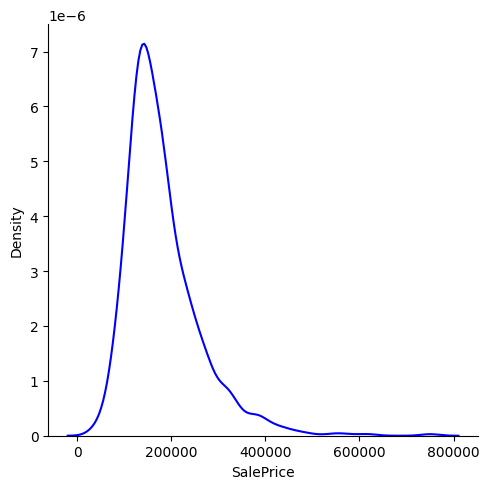

In [13]:
import seaborn as sb
sb.displot(label, color='b', kind='kde')
#plotted a kernel density estimation graph using seaborn. 
#Results indicate that majority of SalePrice values lie just below the $200,000 value, 
# most likely around $180,000.

array([[<Axes: title={'center': 'Id'}>,
        <Axes: title={'center': 'MSSubClass'}>,
        <Axes: title={'center': 'LotFrontage'}>,
        <Axes: title={'center': 'LotArea'}>,
        <Axes: title={'center': 'OverallQual'}>,
        <Axes: title={'center': 'OverallCond'}>],
       [<Axes: title={'center': 'YearBuilt'}>,
        <Axes: title={'center': 'YearRemodAdd'}>,
        <Axes: title={'center': 'MasVnrArea'}>,
        <Axes: title={'center': 'BsmtFinSF1'}>,
        <Axes: title={'center': 'BsmtFinSF2'}>,
        <Axes: title={'center': 'BsmtUnfSF'}>],
       [<Axes: title={'center': 'TotalBsmtSF'}>,
        <Axes: title={'center': '1stFlrSF'}>,
        <Axes: title={'center': '2ndFlrSF'}>,
        <Axes: title={'center': 'LowQualFinSF'}>,
        <Axes: title={'center': 'GrLivArea'}>,
        <Axes: title={'center': 'BsmtFullBath'}>],
       [<Axes: title={'center': 'BsmtHalfBath'}>,
        <Axes: title={'center': 'FullBath'}>,
        <Axes: title={'center': 'HalfBath'}>,

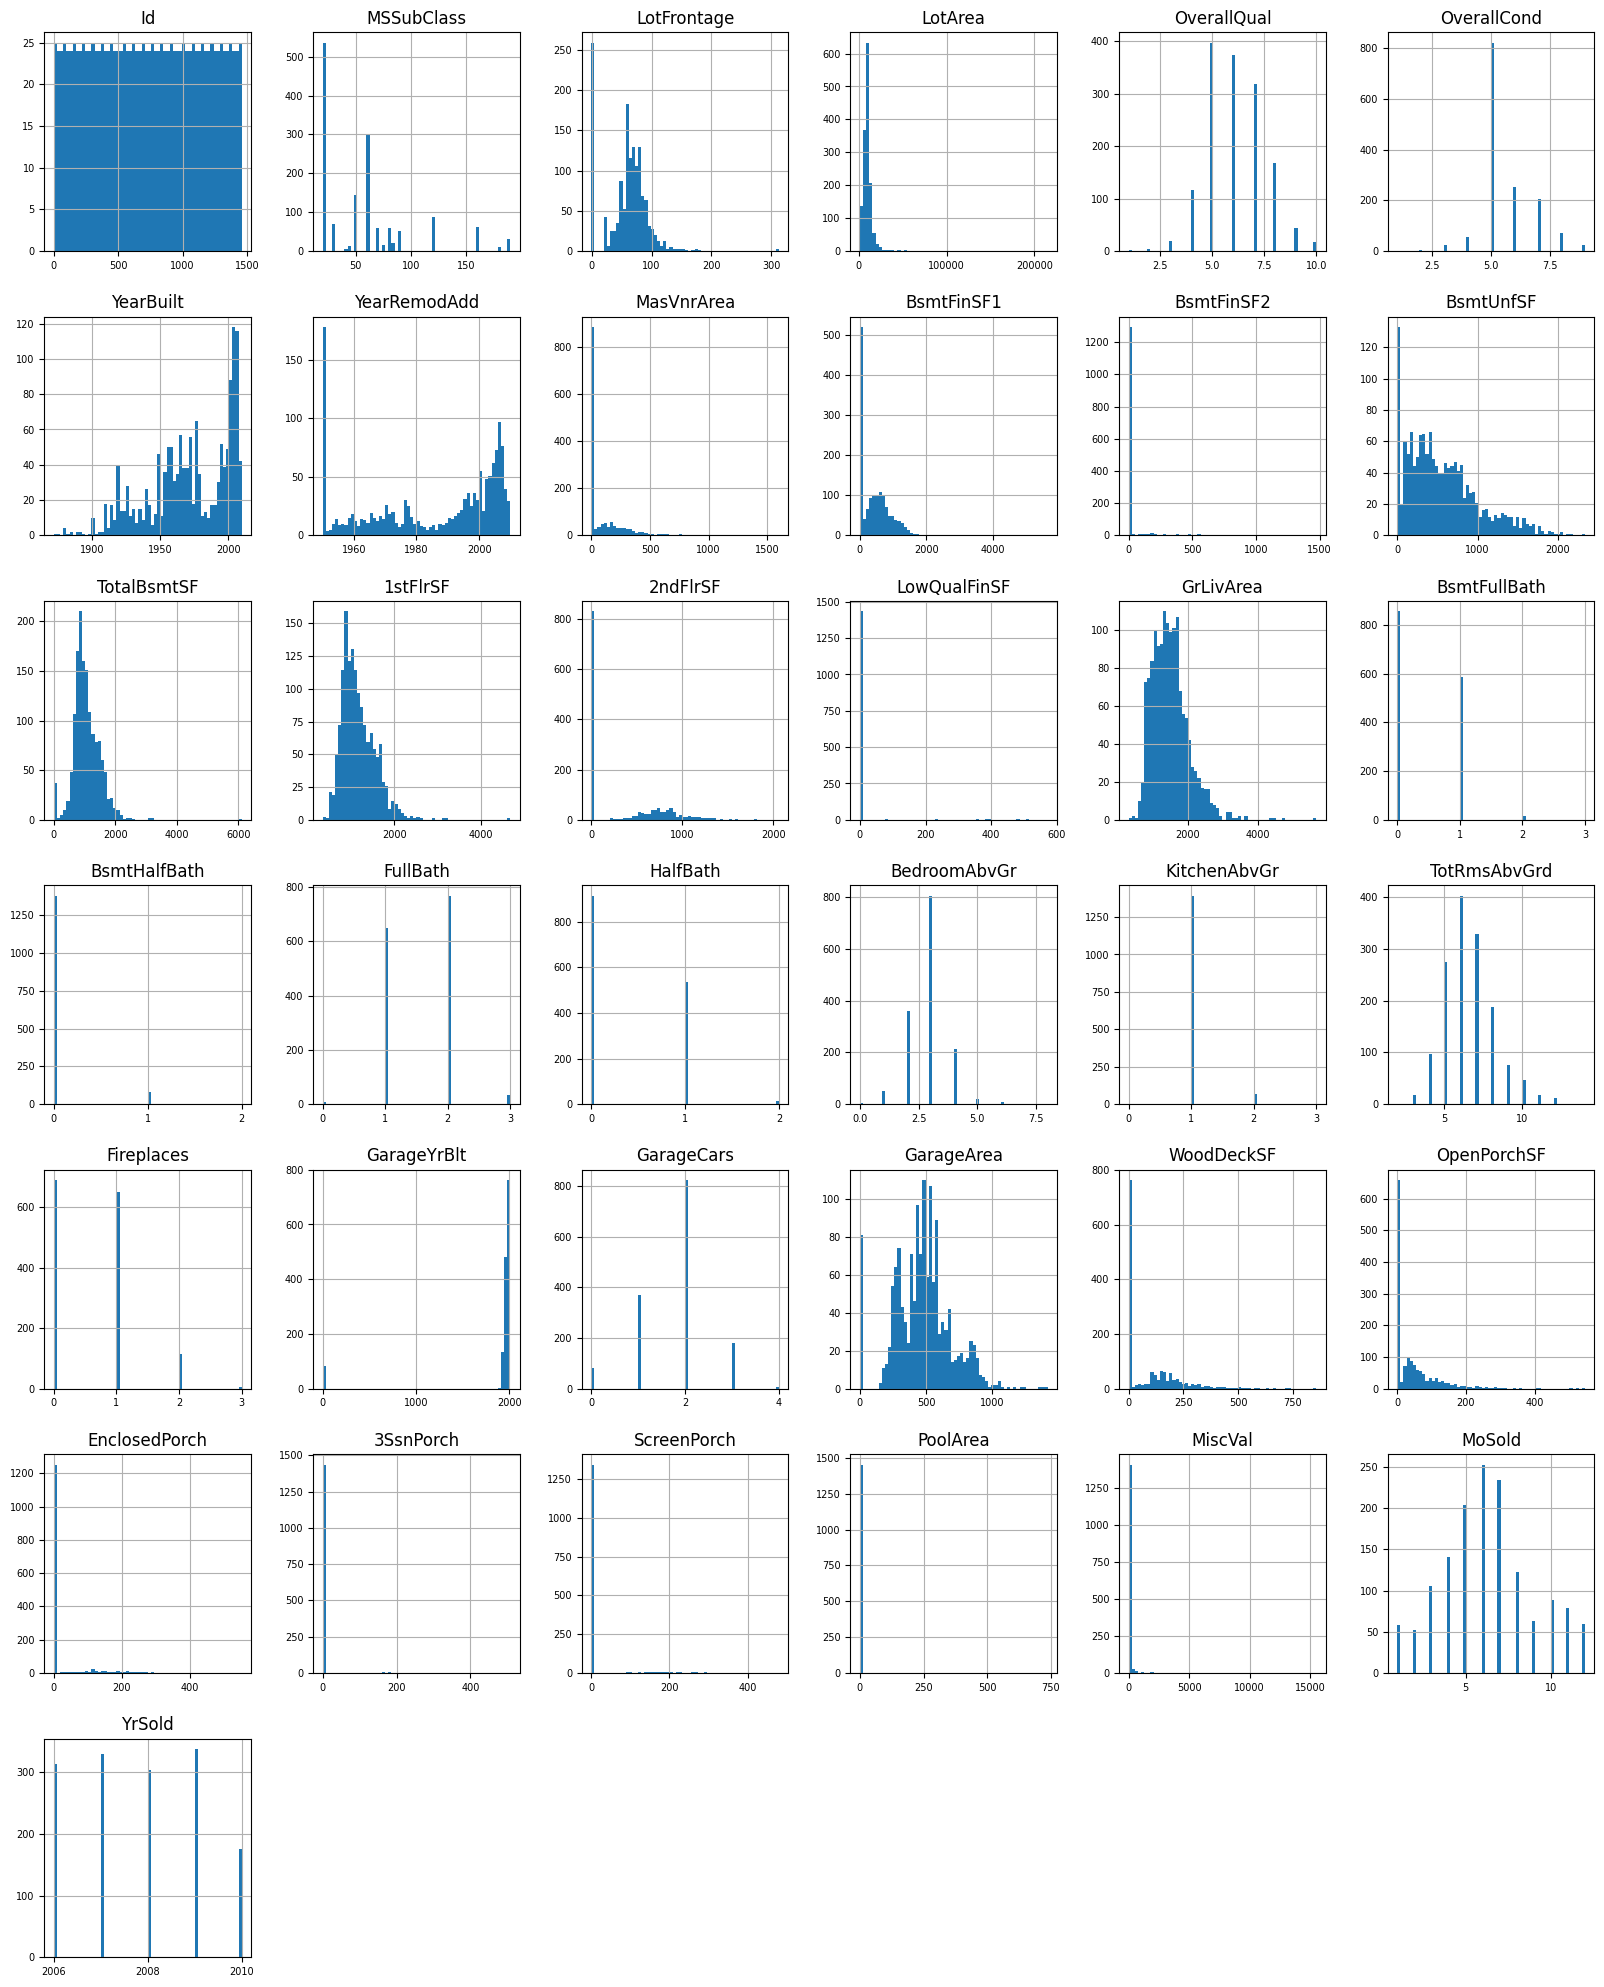

In [14]:
# plot histogram for the numerical columns in this new dataframe
numerical_data = data.select_dtypes(include = ['float64', 'int64'])
numerical_data.hist(bins=60, figsize=(20,25), xlabelsize=7, ylabelsize=7)


Id int64 <class 'numpy.dtype[int64]'>


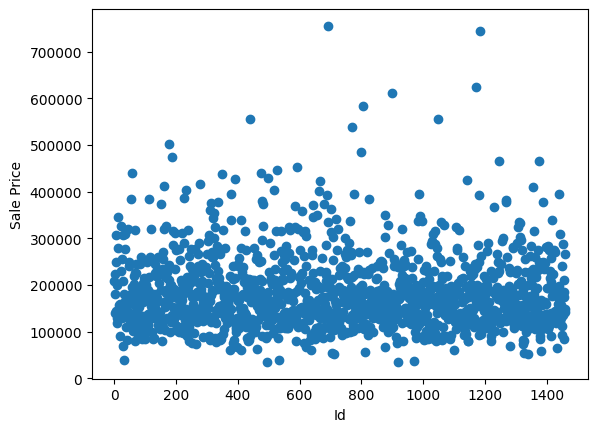

MSSubClass int64 <class 'numpy.dtype[int64]'>


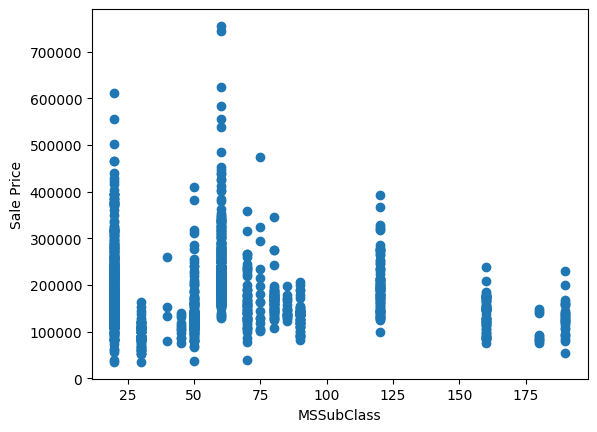

MSZoning object <class 'numpy.dtype[object_]'>


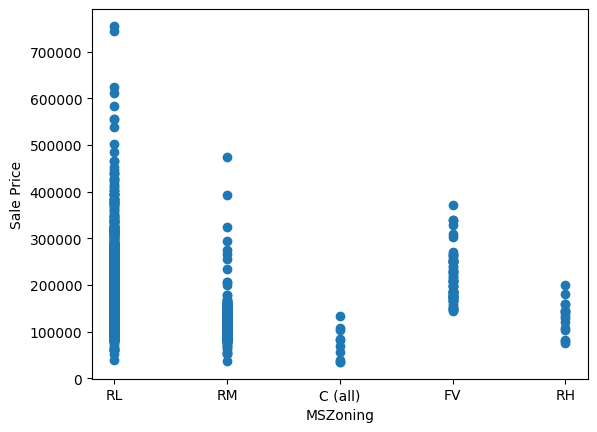

LotFrontage float64 <class 'numpy.dtype[float64]'>


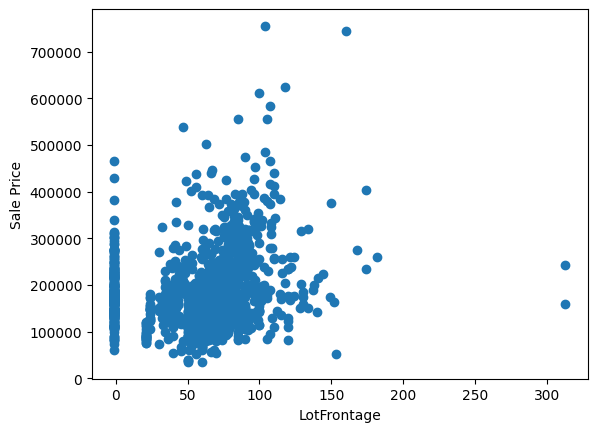

LotArea int64 <class 'numpy.dtype[int64]'>


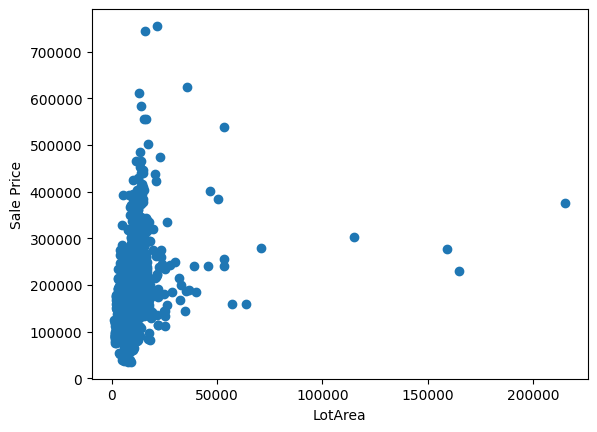

Street object <class 'numpy.dtype[object_]'>


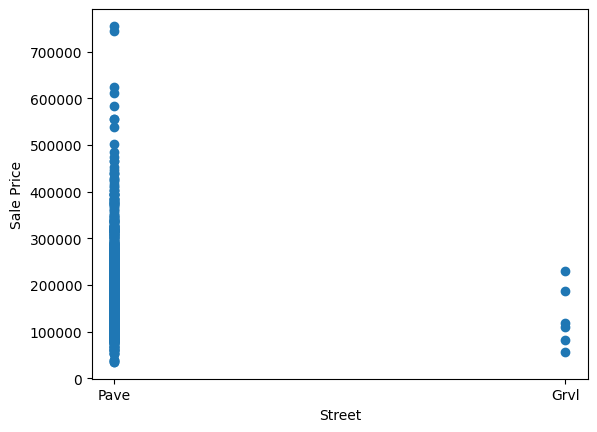

Alley object <class 'numpy.dtype[object_]'>


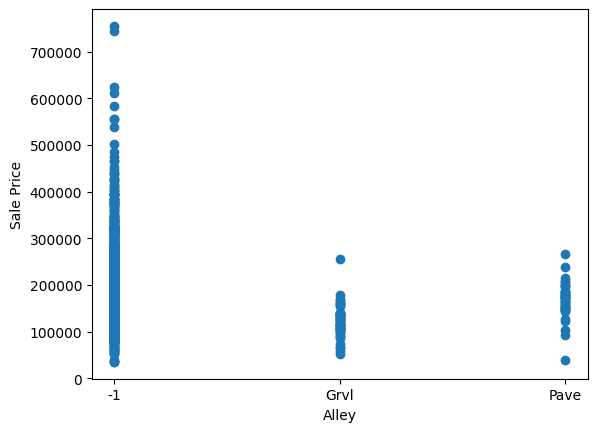

LotShape object <class 'numpy.dtype[object_]'>


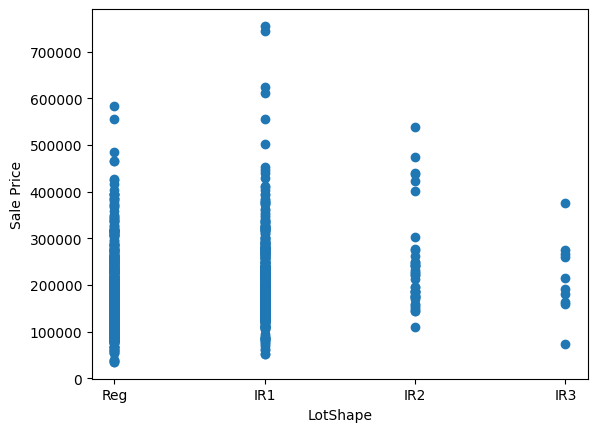

LandContour object <class 'numpy.dtype[object_]'>


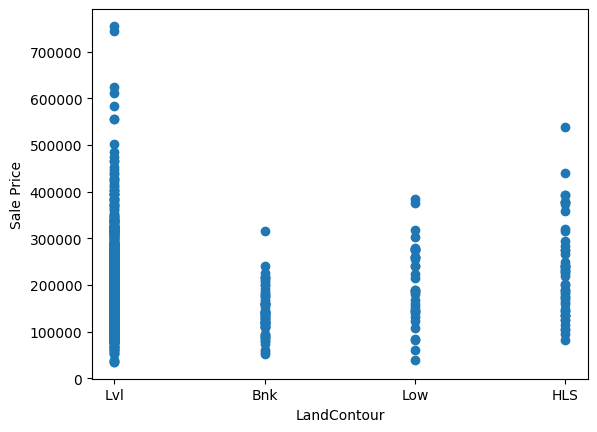

Utilities object <class 'numpy.dtype[object_]'>


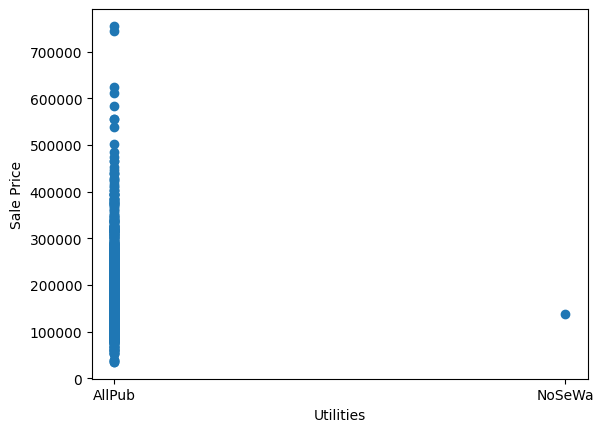

LotConfig object <class 'numpy.dtype[object_]'>


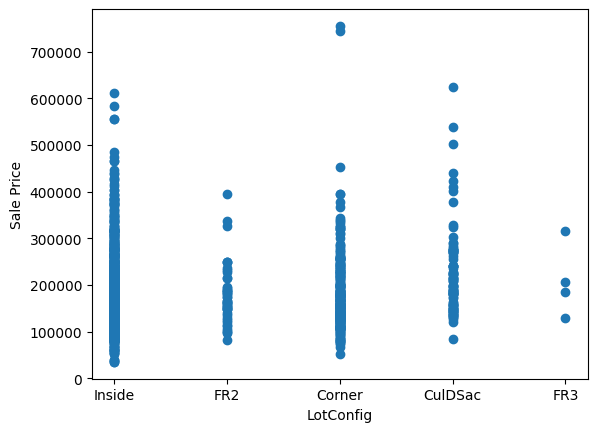

LandSlope object <class 'numpy.dtype[object_]'>


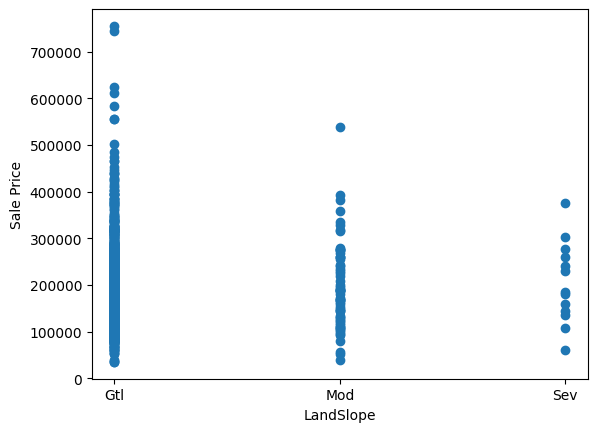

Neighborhood object <class 'numpy.dtype[object_]'>


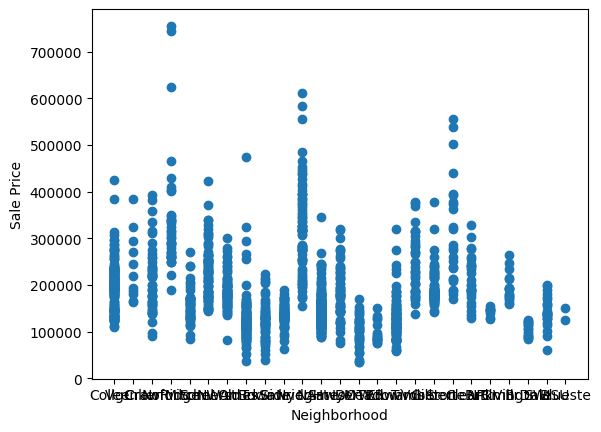

Condition1 object <class 'numpy.dtype[object_]'>


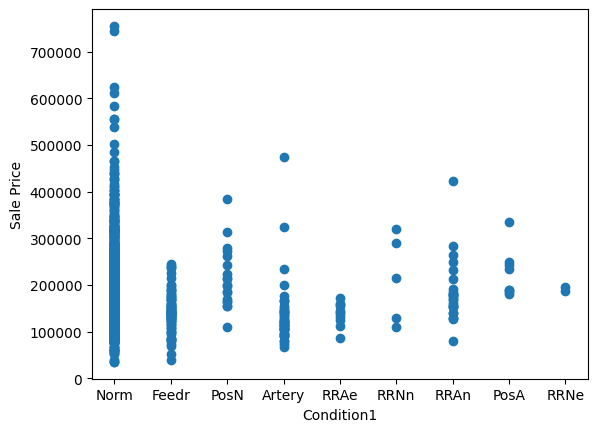

Condition2 object <class 'numpy.dtype[object_]'>


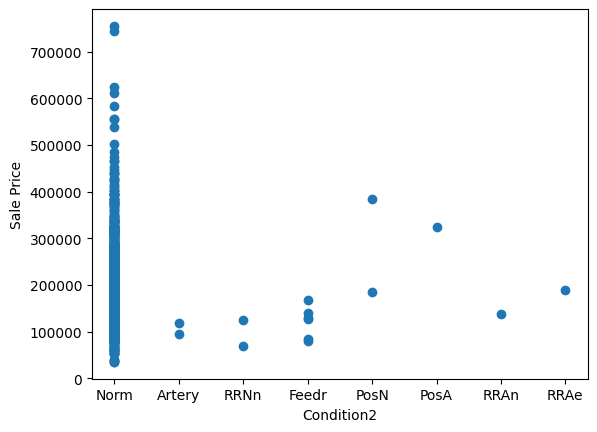

BldgType object <class 'numpy.dtype[object_]'>


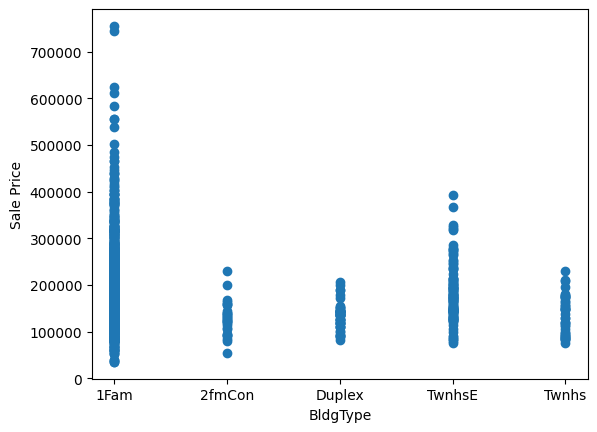

HouseStyle object <class 'numpy.dtype[object_]'>


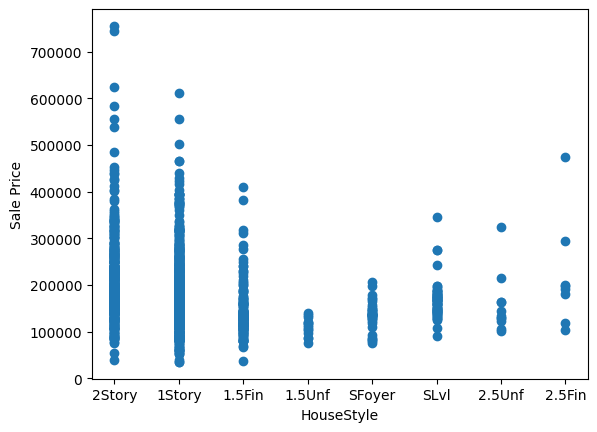

OverallQual int64 <class 'numpy.dtype[int64]'>


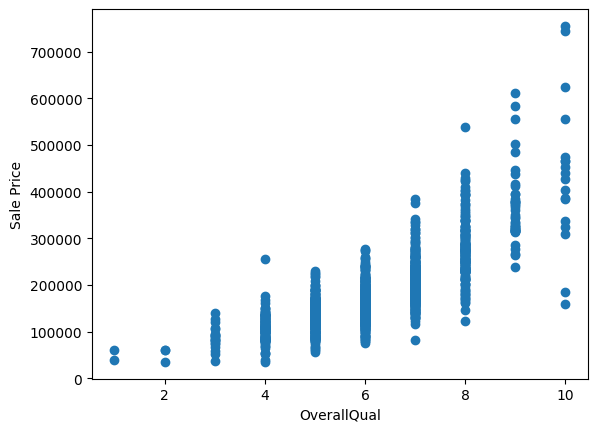

OverallCond int64 <class 'numpy.dtype[int64]'>


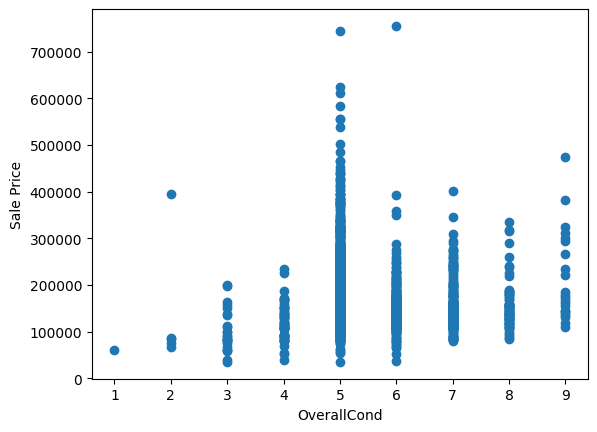

YearBuilt int64 <class 'numpy.dtype[int64]'>


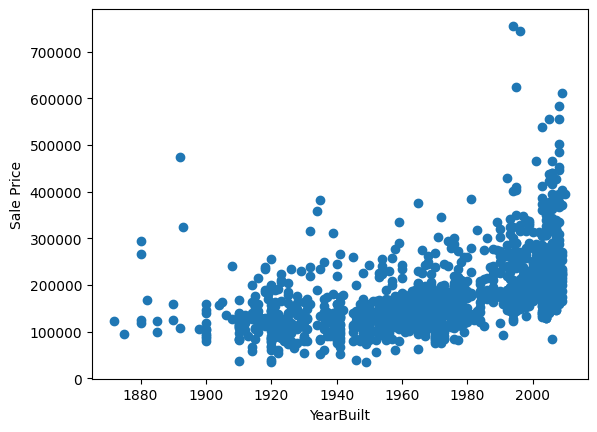

YearRemodAdd int64 <class 'numpy.dtype[int64]'>


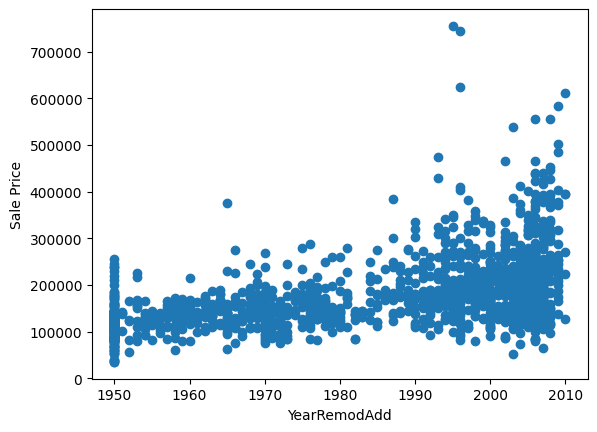

RoofStyle object <class 'numpy.dtype[object_]'>


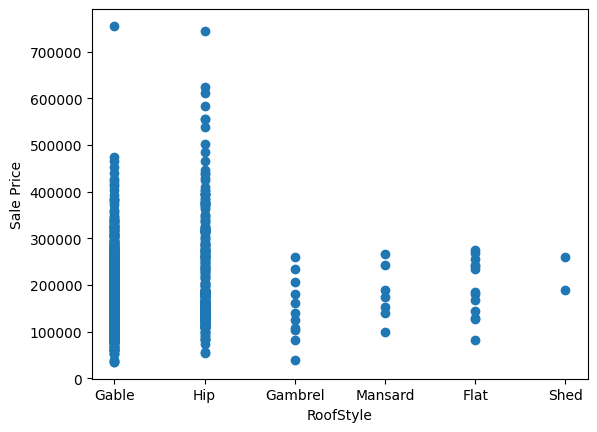

RoofMatl object <class 'numpy.dtype[object_]'>


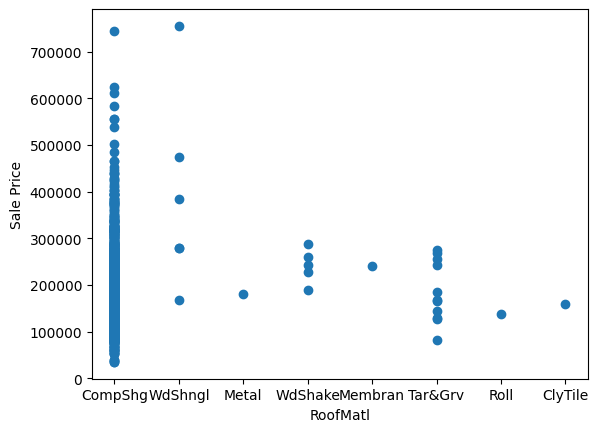

Exterior1st object <class 'numpy.dtype[object_]'>


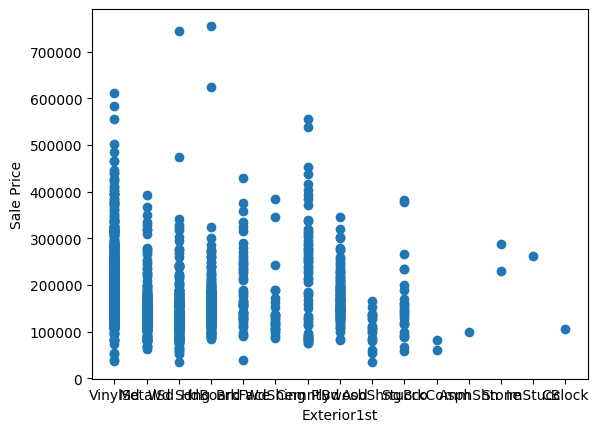

Exterior2nd object <class 'numpy.dtype[object_]'>


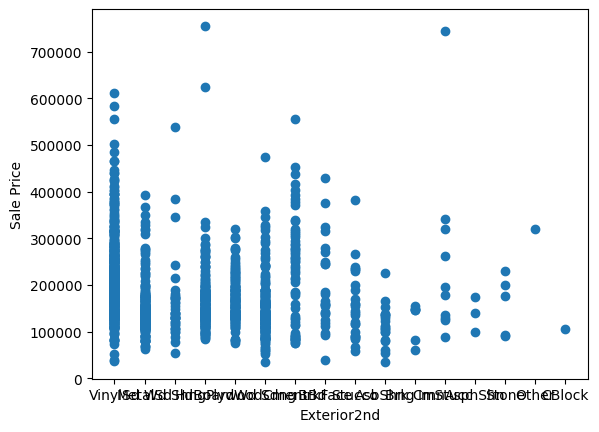

MasVnrType object <class 'numpy.dtype[object_]'>


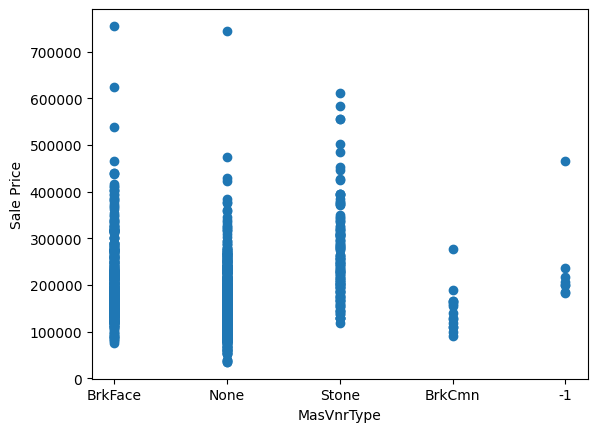

MasVnrArea float64 <class 'numpy.dtype[float64]'>


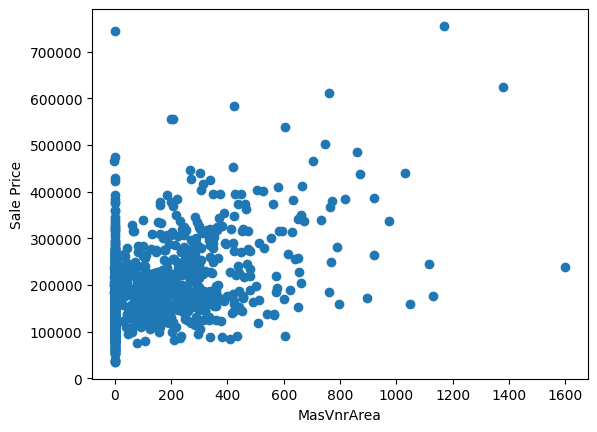

ExterQual object <class 'numpy.dtype[object_]'>


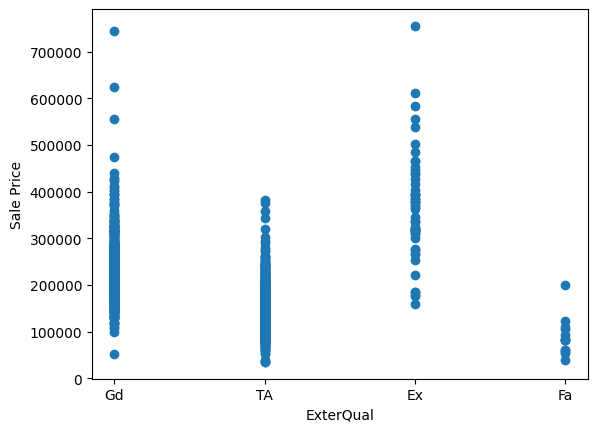

ExterCond object <class 'numpy.dtype[object_]'>


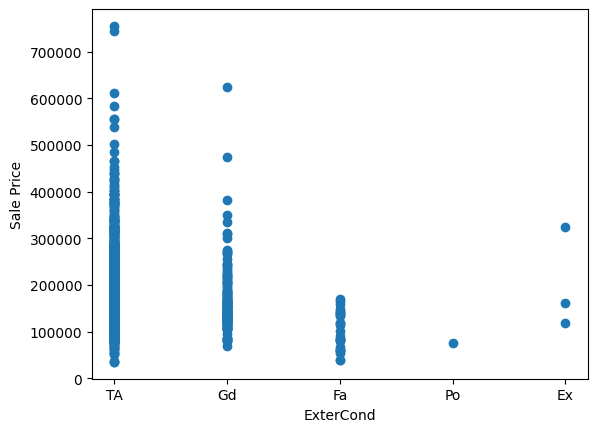

Foundation object <class 'numpy.dtype[object_]'>


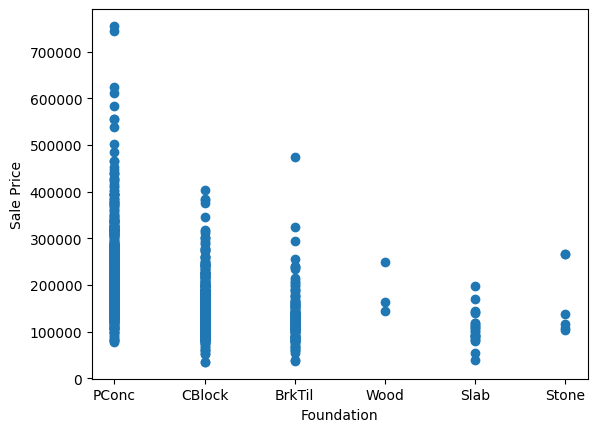

BsmtQual object <class 'numpy.dtype[object_]'>


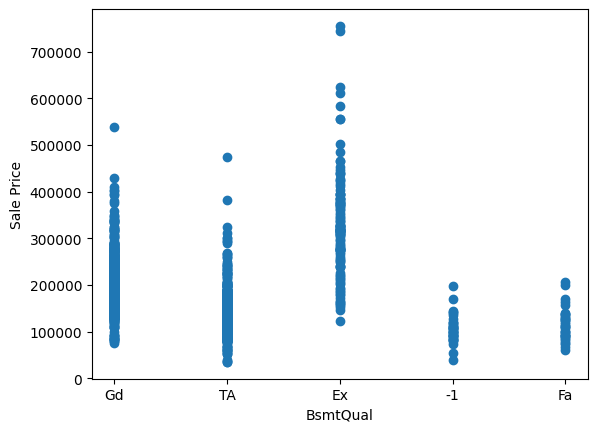

BsmtCond object <class 'numpy.dtype[object_]'>


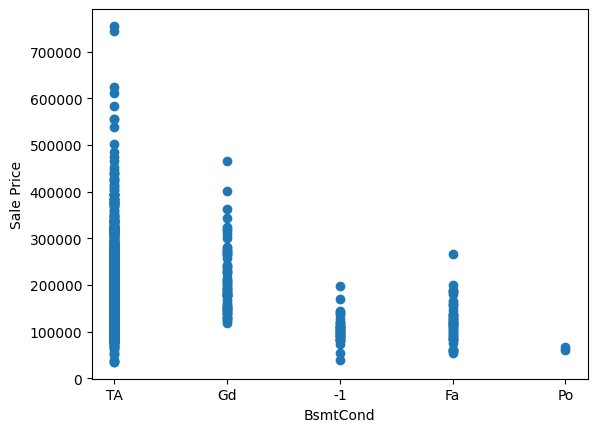

BsmtExposure object <class 'numpy.dtype[object_]'>


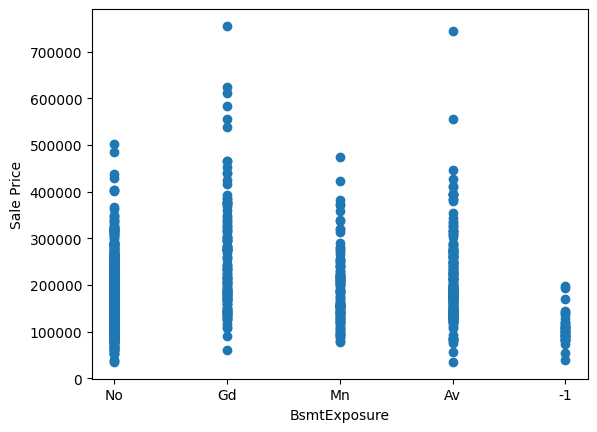

BsmtFinType1 object <class 'numpy.dtype[object_]'>


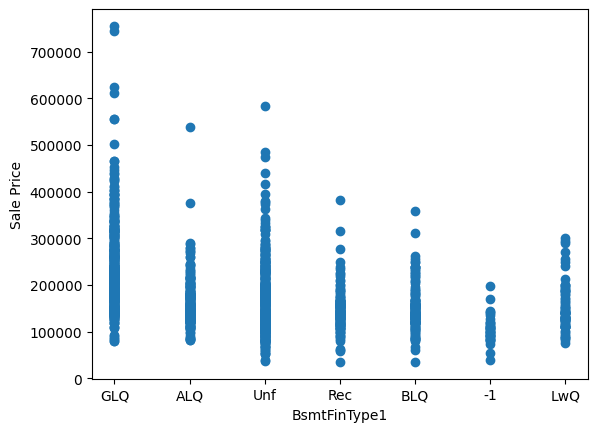

BsmtFinSF1 int64 <class 'numpy.dtype[int64]'>


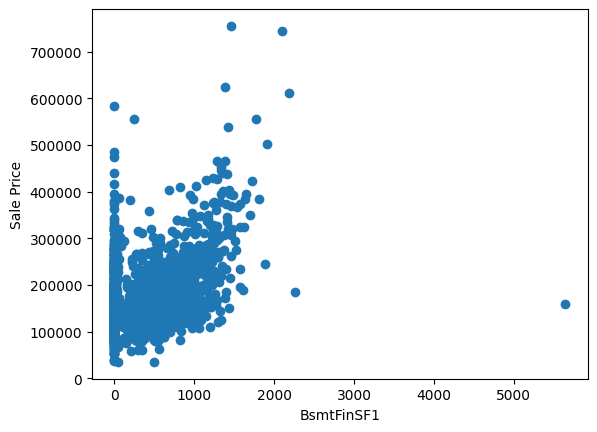

BsmtFinType2 object <class 'numpy.dtype[object_]'>


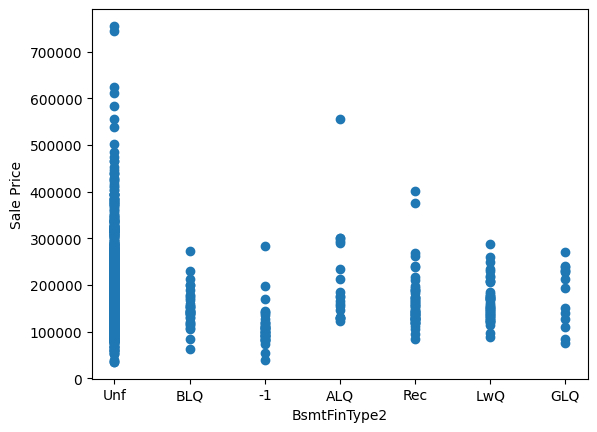

BsmtFinSF2 int64 <class 'numpy.dtype[int64]'>


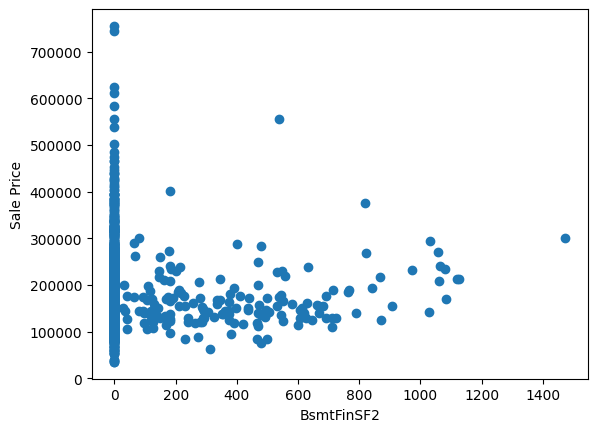

BsmtUnfSF int64 <class 'numpy.dtype[int64]'>


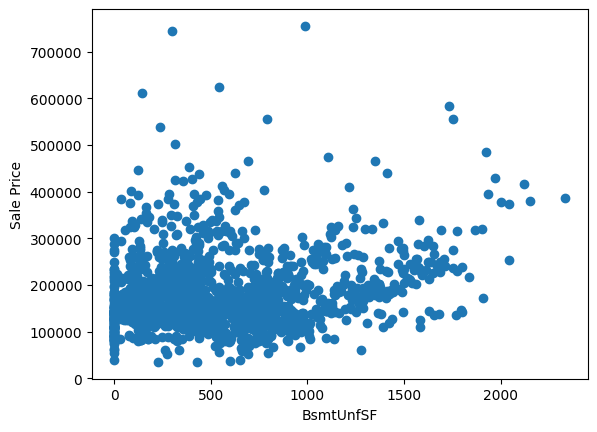

TotalBsmtSF int64 <class 'numpy.dtype[int64]'>


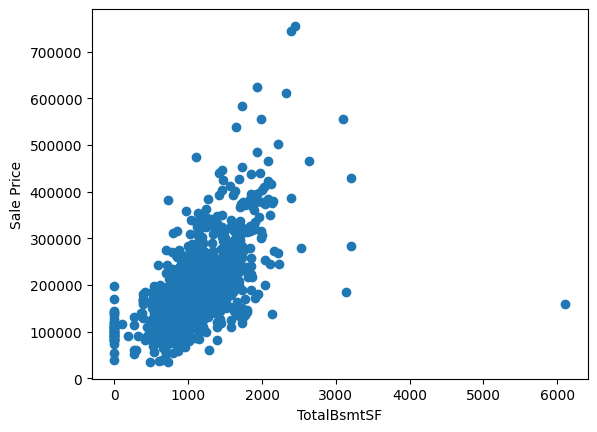

Heating object <class 'numpy.dtype[object_]'>


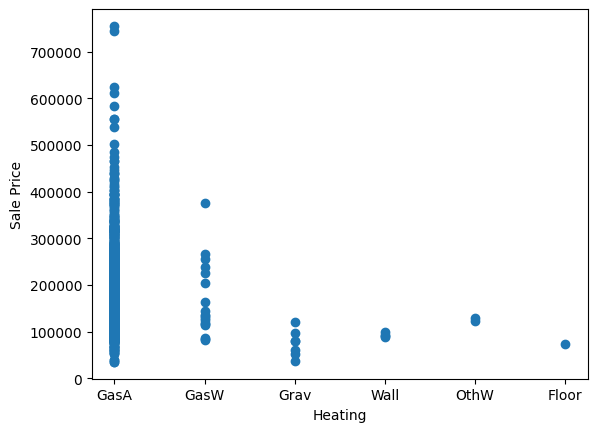

HeatingQC object <class 'numpy.dtype[object_]'>


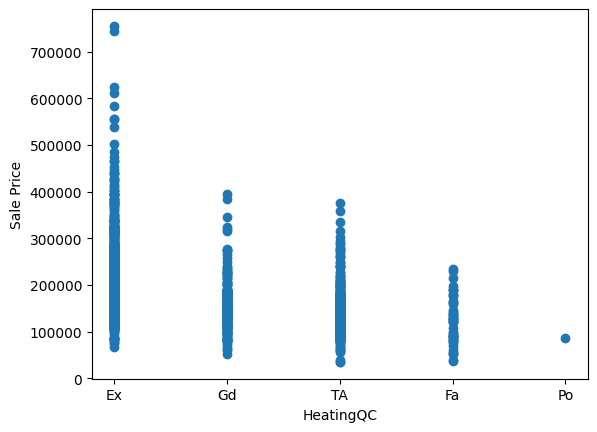

CentralAir object <class 'numpy.dtype[object_]'>


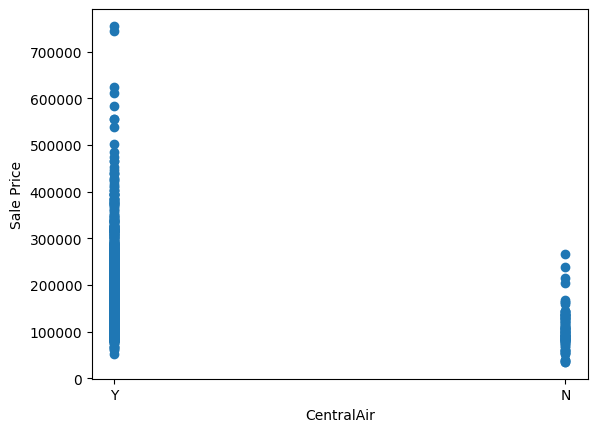

Electrical object <class 'numpy.dtype[object_]'>


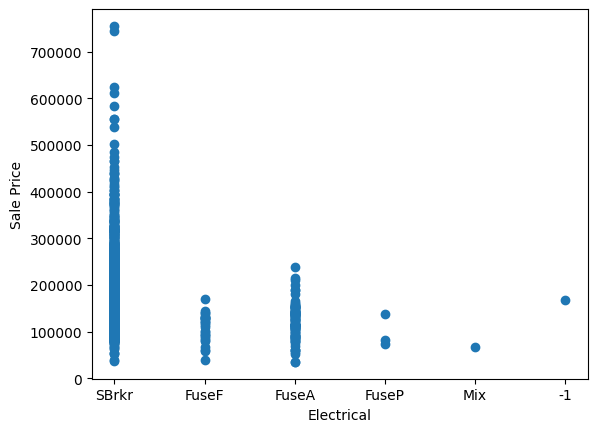

1stFlrSF int64 <class 'numpy.dtype[int64]'>


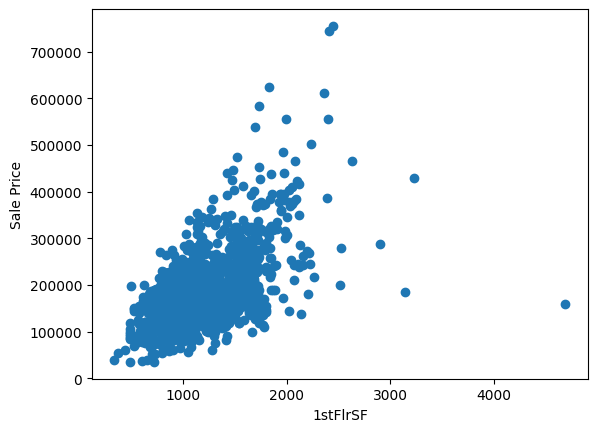

2ndFlrSF int64 <class 'numpy.dtype[int64]'>


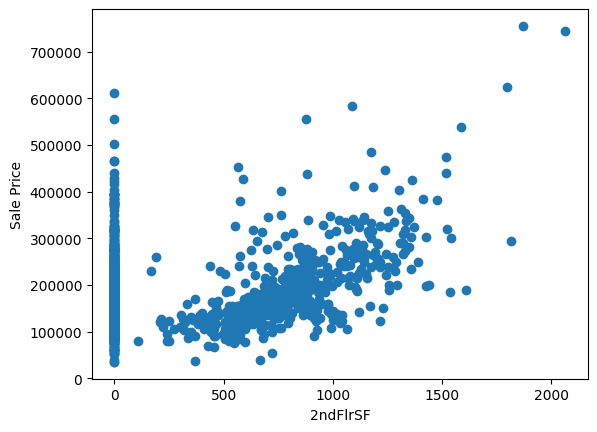

LowQualFinSF int64 <class 'numpy.dtype[int64]'>


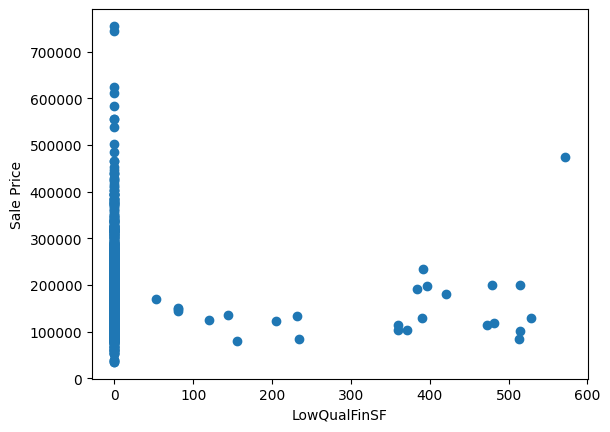

GrLivArea int64 <class 'numpy.dtype[int64]'>


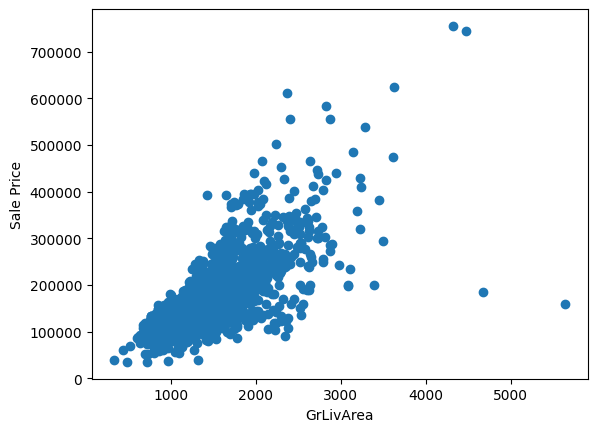

BsmtFullBath int64 <class 'numpy.dtype[int64]'>


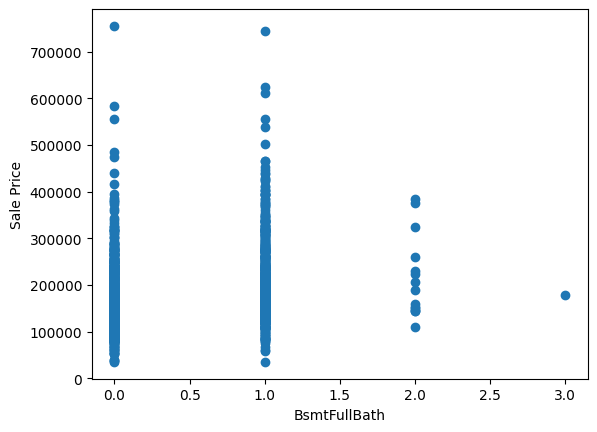

BsmtHalfBath int64 <class 'numpy.dtype[int64]'>


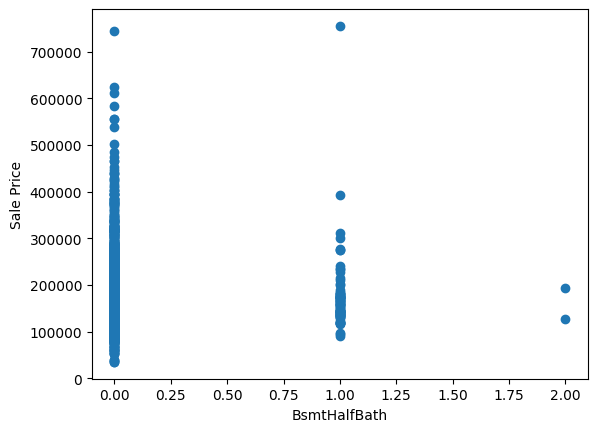

FullBath int64 <class 'numpy.dtype[int64]'>


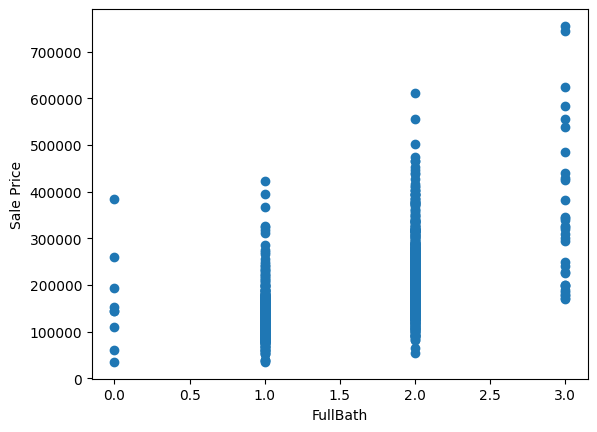

HalfBath int64 <class 'numpy.dtype[int64]'>


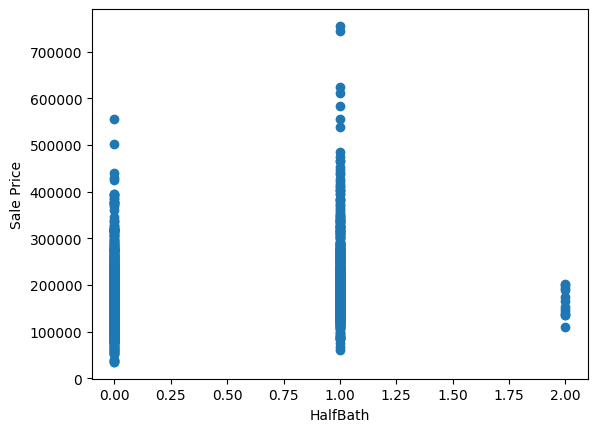

BedroomAbvGr int64 <class 'numpy.dtype[int64]'>


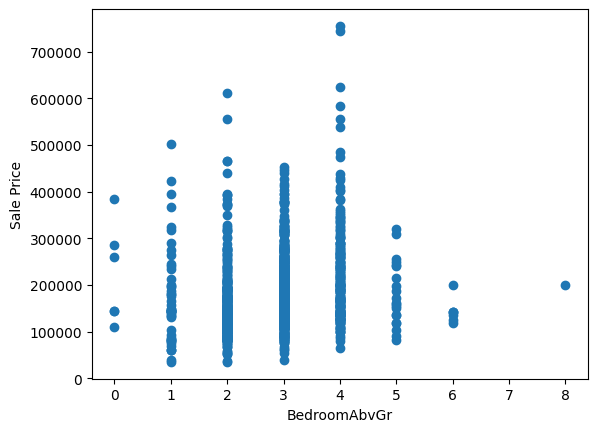

KitchenAbvGr int64 <class 'numpy.dtype[int64]'>


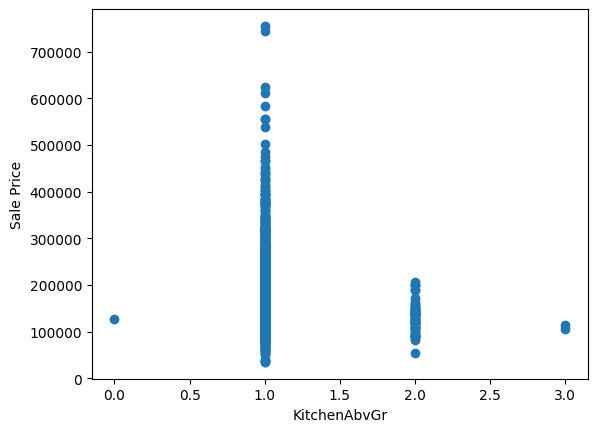

KitchenQual object <class 'numpy.dtype[object_]'>


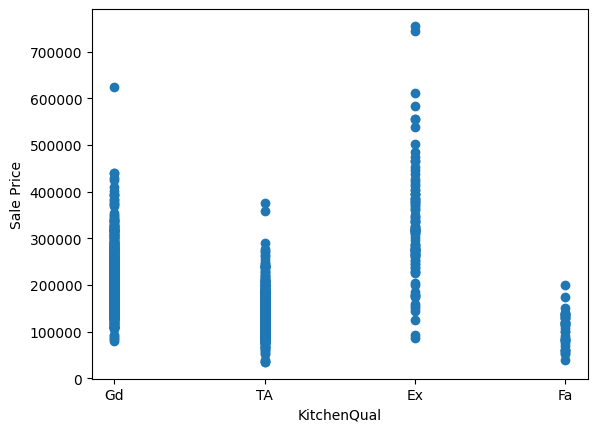

TotRmsAbvGrd int64 <class 'numpy.dtype[int64]'>


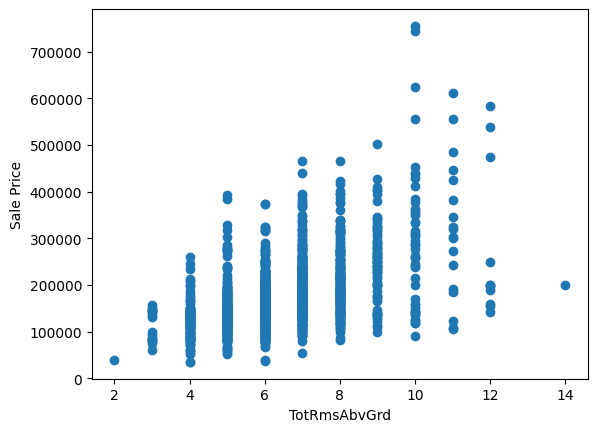

Functional object <class 'numpy.dtype[object_]'>


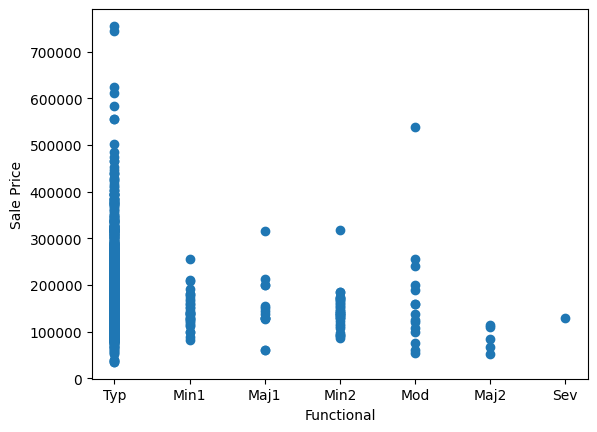

Fireplaces int64 <class 'numpy.dtype[int64]'>


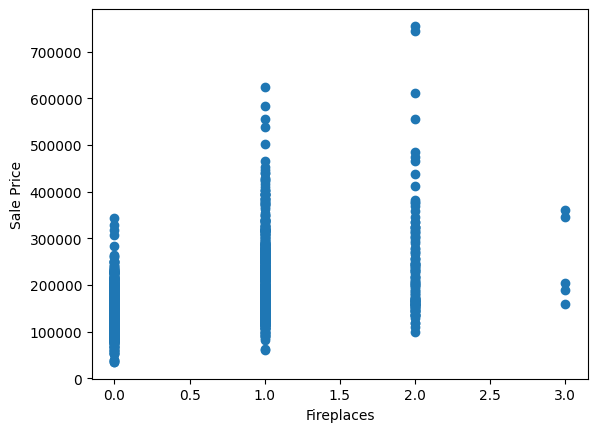

FireplaceQu object <class 'numpy.dtype[object_]'>


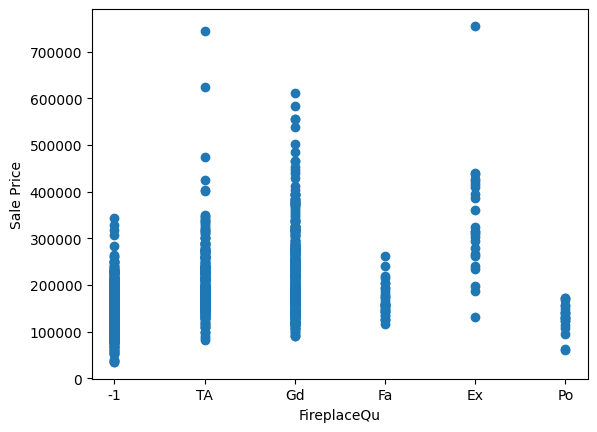

GarageType object <class 'numpy.dtype[object_]'>


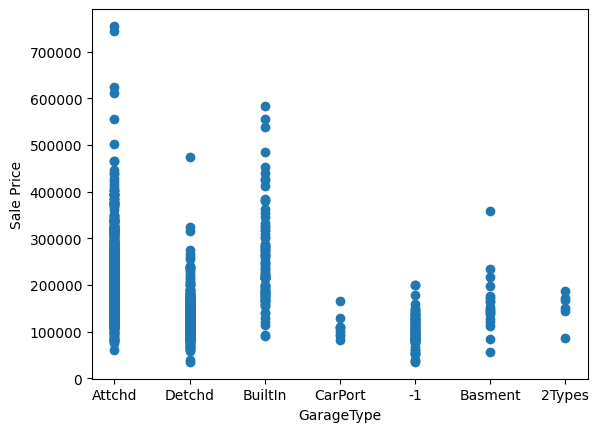

GarageYrBlt float64 <class 'numpy.dtype[float64]'>


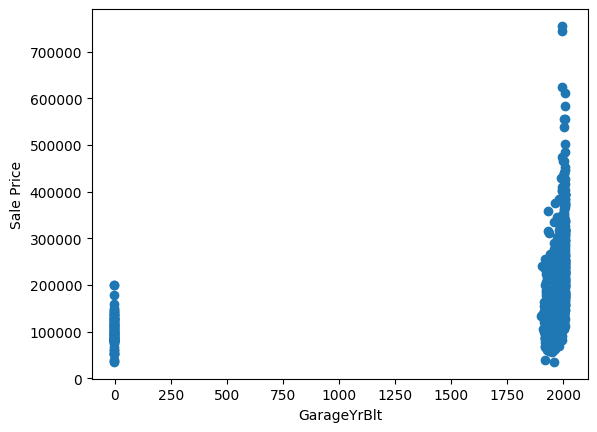

GarageFinish object <class 'numpy.dtype[object_]'>


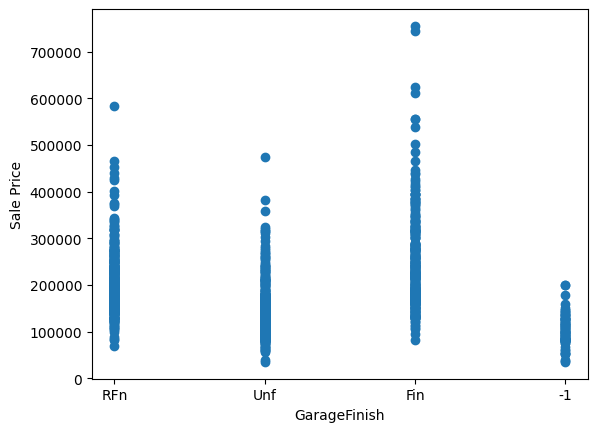

GarageCars int64 <class 'numpy.dtype[int64]'>


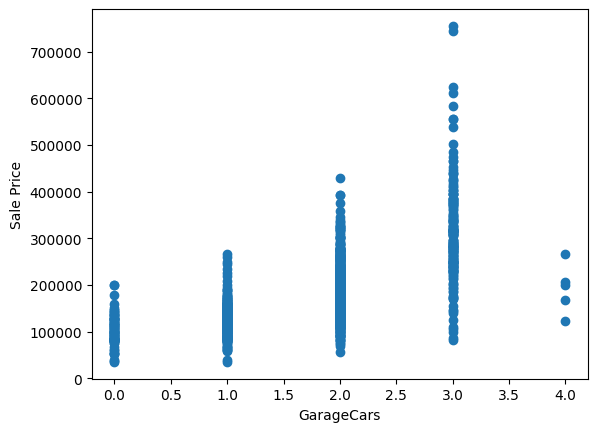

GarageArea int64 <class 'numpy.dtype[int64]'>


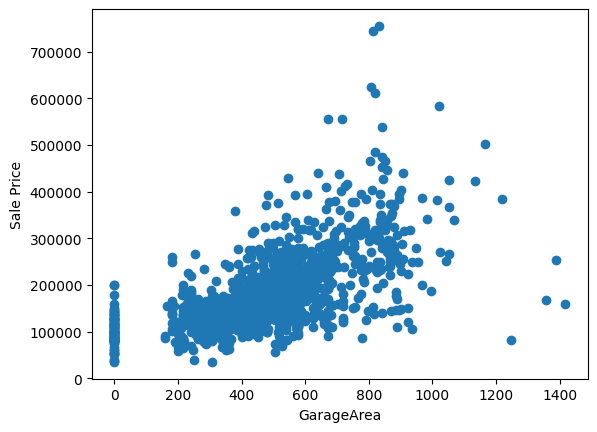

GarageQual object <class 'numpy.dtype[object_]'>


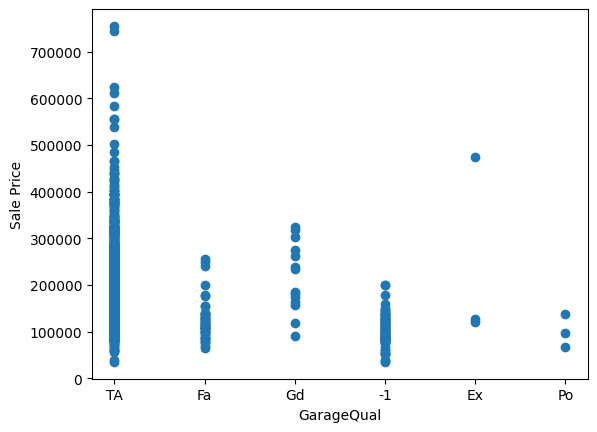

GarageCond object <class 'numpy.dtype[object_]'>


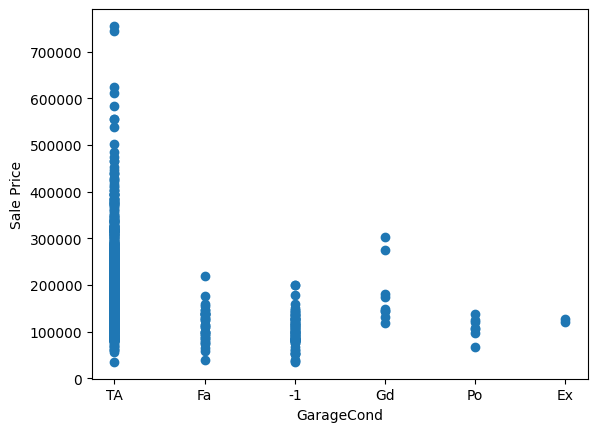

PavedDrive object <class 'numpy.dtype[object_]'>


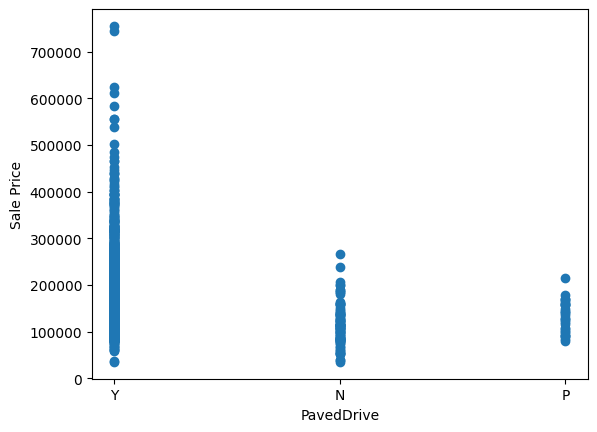

WoodDeckSF int64 <class 'numpy.dtype[int64]'>


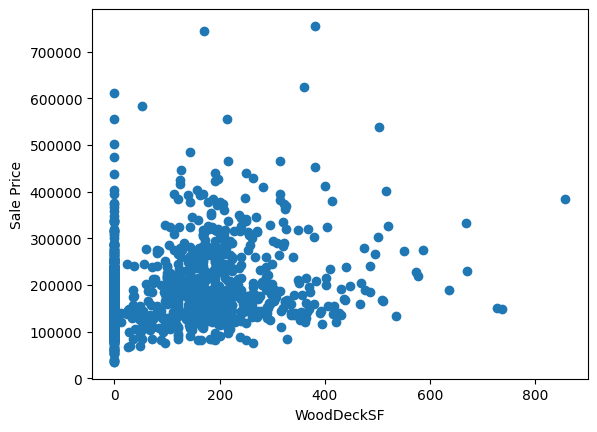

OpenPorchSF int64 <class 'numpy.dtype[int64]'>


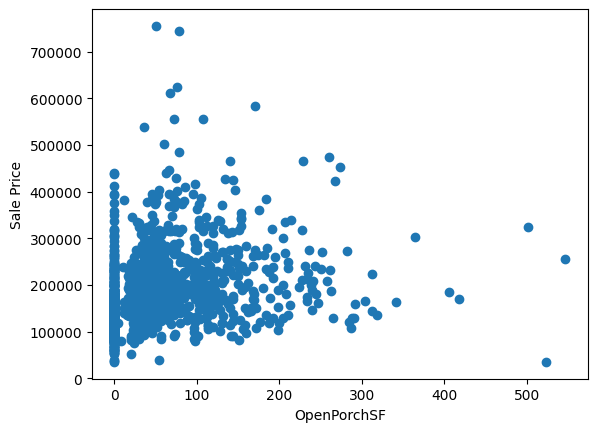

EnclosedPorch int64 <class 'numpy.dtype[int64]'>


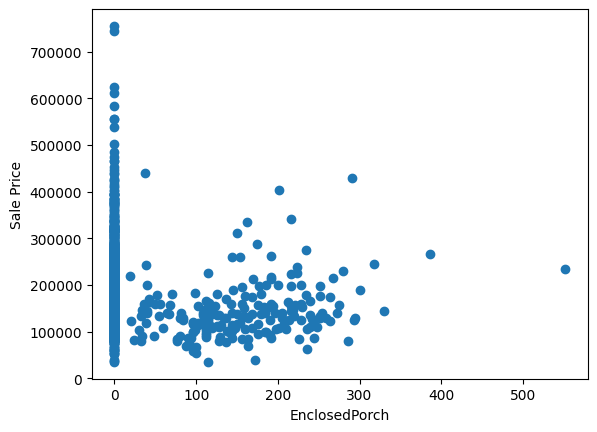

3SsnPorch int64 <class 'numpy.dtype[int64]'>


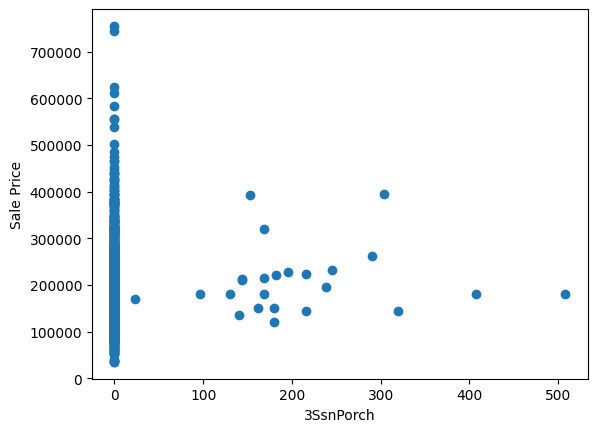

ScreenPorch int64 <class 'numpy.dtype[int64]'>


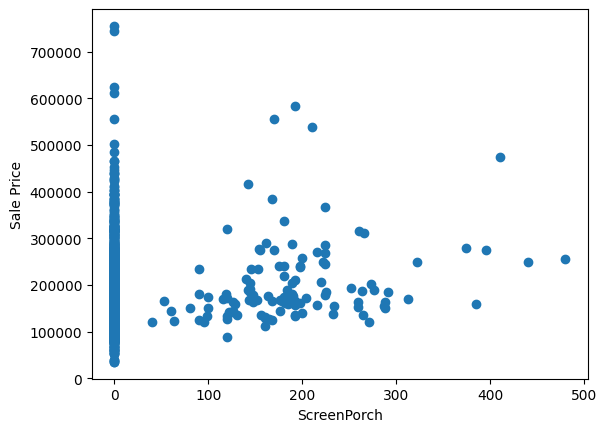

PoolArea int64 <class 'numpy.dtype[int64]'>


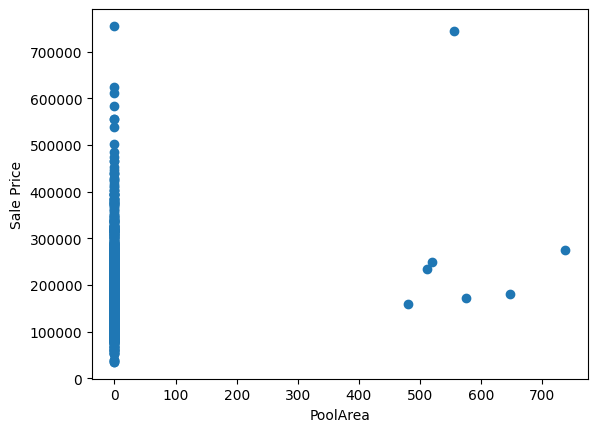

PoolQC object <class 'numpy.dtype[object_]'>


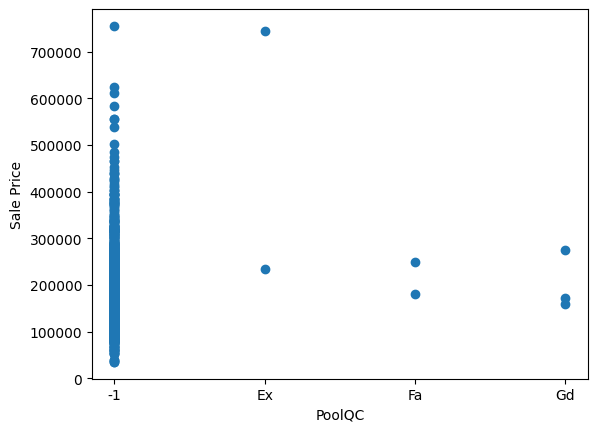

Fence object <class 'numpy.dtype[object_]'>


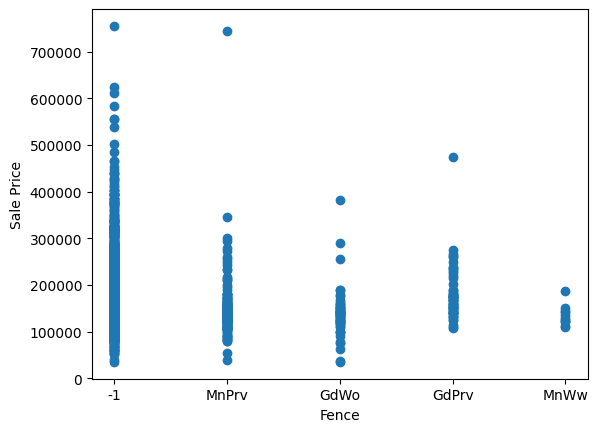

MiscFeature object <class 'numpy.dtype[object_]'>


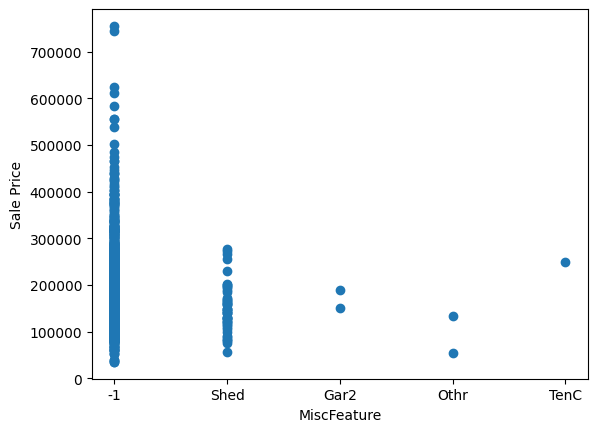

MiscVal int64 <class 'numpy.dtype[int64]'>


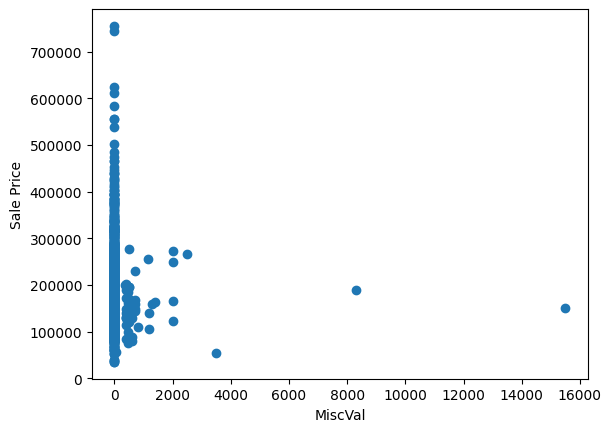

MoSold int64 <class 'numpy.dtype[int64]'>


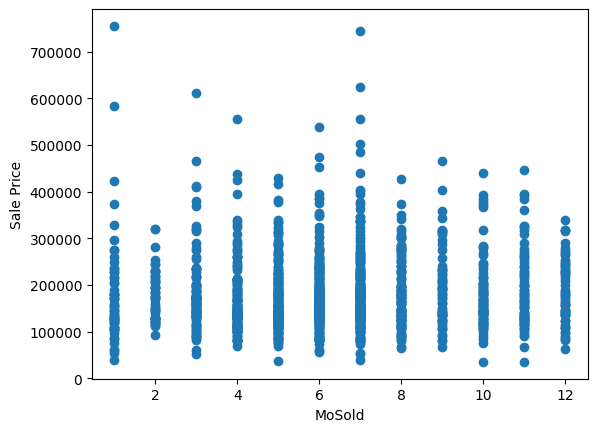

YrSold int64 <class 'numpy.dtype[int64]'>


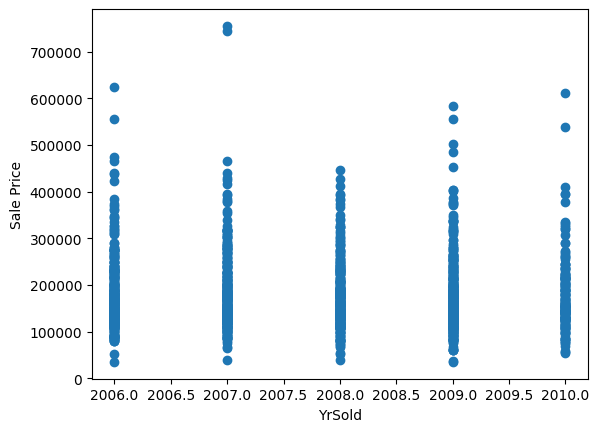

SaleType object <class 'numpy.dtype[object_]'>


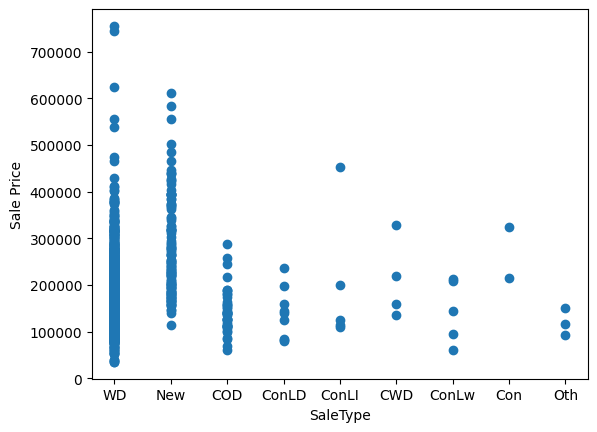

SaleCondition object <class 'numpy.dtype[object_]'>


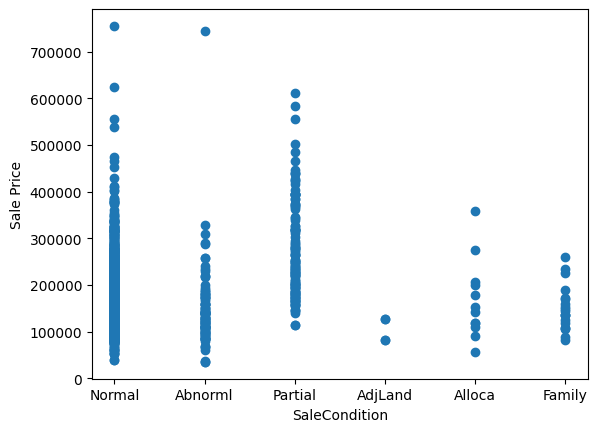

In [15]:
import numpy as np
x = 8
y = 10
for col in data.columns:
    plt.xlabel(col)
    plt.ylabel("Sale Price")
    print(col, data.dtypes[col], type(data.dtypes[col]) )
    if(data.dtypes[col] == np.object_):
        plt.scatter(x = data[col].astype(str), y = label)
    else:
        plt.scatter(x = data[col], y = label)
    plt.show()

We can also use linear regression to extract important variables. This can be done by
fitting a linear regression model on the data. The model can then return to you a p-value
for each variable, which measures the significance of each variable to the regression. 
The summmary below contains the information for each variable, as well as the coeffecient
for each. These are not the final coefficients; we use statsmodel to obtain the summary, but 
we will use sklearn for the true regression.

In [16]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
import statsmodels.api as sm

from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

class CustomLinearRegression():
    def __init__(self, columns: list):
        self.columns = columns
        self.model = LinearRegression()
        
    def fit_CV(self, data, labels):
        data = data[self.columns]
        print(cross_val_score(self.model,data, labels, cv=5, scoring='r2'))

    def most_important_features(self, data, labels):
        sub_data = data[self.columns]
        labels = labels.astype(float)
        model = sm.OLS(labels, sub_data).fit()
        
        print(model.summary())

numeric_data = encoded_data.select_dtypes(include = "number")
linReg.most_important_features(encoded_data, label)
    

NameError: name 'linReg' is not defined

### Machine Learning Models
Now we will begin testing machine learning models on our data. Our task is a regression task;
we are attempting to predict a constant value based on the features of the house. We will try many different types of models such as linear regression, decision forest, .... 

We will start with the linear regression. The linear regression fits coefficients to each
variable. It is important that each variable is numeric for linear regression, however
scaling and PCA won't be necessary here. 

Results: The linear regression obtains the following values over five-fold linear regression:
[0.86741619 0.81658684 0.83597586 0.83212263 0.63287803],
with an average R-squared score of 0.7969959099999999.

In [ ]:
linReg = CustomLinearRegression(columns = numeric_data.columns)
linReg.fit_CV(encoded_data, label)

Next, we attempt regression using a Random Forest Regressor. The Random Forest Regressor
is able to obtain an R2 score of 0.9011. Using the elbow method on the RMSE plot, it seems
that the best number of decision stumps is around 50.

In [19]:
from tensorflow_addons.metrics import RSquare
data = pd.read_csv('train.csv')
data_tfdf = data.drop('Id', axis=1)
data_tfdf.head()
# dropped ID column of dstaset since it's not necessary for computation and analysis
numerical_data = data_tfdf.select_dtypes(include = ['float64', 'int64'])
numerical_data.head()
# create a df that only contains columns of numerical values to plot histograms for

import tensorflow as tf
import tensorflow_decision_forests as tfdf
from sklearn.model_selection import train_test_split

training_df, validation_df = train_test_split(data_tfdf, test_size = 0.3)
print(len(training_df))
print(len(validation_df))

# import tensorflow and tensorflow decision trees
# split the data into a training and test set for results
training_tf = tfdf.keras.pd_dataframe_to_tf_dataset(training_df, label='SalePrice', task = tfdf.keras.Task.REGRESSION)
validation_tf = tfdf.keras.pd_dataframe_to_tf_dataset(validation_df, label='SalePrice', task = tfdf.keras.Task.REGRESSION)
# before fitting the model, we must convert the dataframe to tf datasets and also set the task as regression instead of the classification default
tf_rand_forest = tfdf.keras.RandomForestModel(task=tfdf.keras.Task.REGRESSION)

tf_rand_forest.fit(training_tf)

tf_rand_forest.compile(metrics=[RSquare()])

eval = tf_rand_forest.evaluate(x=validation_tf, return_dict=True)
for key, value in eval.items():
  print(f"{key}: {value:.4f}")

#create a random forest model from the decision forest library for regression
# fit the model using the training tf dataset, and compile metrics using the mse metric
# we get a dict of the evaluation results of the model performance and print out the loss and mse
# no loss and a rather high MSE
tfdf.model_plotter.plot_model_in_colab(tf_rand_forest, tree_idx=3, max_depth=4)
inspector = tf_rand_forest.make_inspector().training_logs()
plt.plot([log.num_trees for log in inspector], [log.evaluation.rmse for log in inspector])
plt.xlabel("Number of Trees")
plt.ylabel("RMSE")
plt.show()

ModuleNotFoundError: No module named 'tensorflow'

Using KNN, we achieved good accuracy scores on our model. Selecting the highly correlated features gave us a better accuracy compared to using all of the processed data (80% vs 72%). This was as expected, however we wanted to see how much our feature selection impacted model accuracy.

In [130]:
# Using KNN (KN Regressor model) on the selected features
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

numeric_data = filtered_data

scaler = StandardScaler()
# The use of PCA did not affect the accuracy of this model negatively 
pca = PCA()
knreg = KNeighborsRegressor()

pipeline = Pipeline(steps=[('scaler', scaler), ('pca', pca), ('knreg', knreg)])
scores = cross_val_score(pipeline, numeric_data, label, cv=5, scoring='r2')

print("R2 Score:", scores.mean())

Average Accuracy: 0.8107808886681163


In [132]:
# Using KNN (KN Regressor model) on all the data using PCA 
# Data is one-hot encoded and all ordinal variables translated into ranked #s
numeric_data = encoded_data.select_dtypes(include = 'number')

scaler = StandardScaler()
pca = PCA()
knreg = KNeighborsRegressor()


pipeline = Pipeline(steps=[('scaler', scaler), ('pca', pca), ('knreg', knreg)])
scores = cross_val_score(pipeline, numeric_data, label, cv=5, scoring='r2')

print("R2 Score:", scores.mean())

R2 Score: 0.7638514527730091


The Neural Network model came out with a good accuracy. However, the KNN model above and AdaBoost models below took less time to train and achieved higher accuracy scores. We don't believe that these higher accuracy models are overfitted to the training data since those accuracies are around 80%. 

In [133]:
# Using a Neural Network model (MLP Regressor) to predict house prices
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor

from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

@ignore_warnings(category=ConvergenceWarning)
def run_nn():
    numeric_data = filtered_data
    scaler = StandardScaler()
    pca = PCA()
    neuralnet = MLPRegressor()
    pipeline = Pipeline(steps=[('scaler', scaler), ('nn', neuralnet)])

    param_grid = {'nn__hidden_layer_sizes': list(range(10,20,10)),
                'nn__activation': ['logistic', 'tanh', 'relu'], 
                'nn__solver': ['lbfgs', 'sgd', 'adam']}

    grid_search = GridSearchCV(pipeline, param_grid, cv=5)
    scores = cross_val_score(grid_search, numeric_data, label, cv=5, scoring='r2')
    print('R2 Score:', scores.mean())

run_nn()

/Users/amalbabu/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_base.py:174: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/amalbabu/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/extmath.py:152: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/amalbabu/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/extmath.py:152: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/amalbabu/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_base.py:174: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/amalbabu/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/extmath.py:152: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/amalbabu/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/extmath.py:152: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/amalbabu/opt/

R2 Score: 0.7820155306635741


/Users/amalbabu/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
5 fits failed out of a total of 45.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/amalbabu/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/amalbabu/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/amalbabu/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py",

Using an SVM did not give us good results at all. The accuracies are incredibly low and this model is not anywhere near feasible. Any other model we created works significantly better than this one.

In [126]:
# TODO: Figure out why this model has horrible accuracy.
# Using SVM (SV Regression) to predict house prices
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report, accuracy_score

# numeric_data = filtered_data
numeric_data = encoded_data.select_dtypes(include = 'number')

scaler = StandardScaler()
svr = SVR()

pipeline = Pipeline(steps=[('scaler', scaler), ('svr', svr)])
param_grid = {
    'svr__kernel': ['linear', 'rbf', 'poly']
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5)
scores = cross_val_score(grid_search, numeric_data, label, cv=10, scoring='r2')
print('R2 Score:', scores.mean())

Accuracy: 0.13481709346704224


The AdaBoost model overall acheived really good accuracy. Using all the data versus only the selected features from the data had a neglible difference in accuracy for the AdaBoost model.

In [127]:
# Using AdaBoost (Regressor) on selected features to predict house prices 
from sklearn.ensemble import AdaBoostRegressor

numeric_data = filtered_data

abr = AdaBoostRegressor()
param_grid = {'n_estimators': [50,100,150]}

grid_search = GridSearchCV(abr, param_grid, cv=5)
scores = cross_val_score(grid_search, numeric_data, label, cv=5, scoring='r2')
print('R2 score:', scores.mean())

R2 score: 0.7909694401651481


In [128]:
# Using AdaBoost with all the data rather than only selected features
numeric_data = encoded_data.select_dtypes(include = 'number')

abr = AdaBoostRegressor()
param_grid = {'n_estimators': [50,100,150]}

grid_search = GridSearchCV(abr, param_grid, cv=5)
scores = cross_val_score(grid_search, numeric_data, label, cv=5, scoring='r2')
print('R2 Score:', scores.mean())

R2 Score: 0.7929794415418547


Next, we try some anomaly detection. While this isn't exactly the regresssion task
that we this project is cenetered around we found that anomaly detection is a very
practical tool. If we are able to find houses that are considered "anomalies" with
respect to the other houses, it may be a house we want to buy. For example, a house 
that is very undrevalued with respect to its features would show up as an outlier,
which can be a useful tool for those who want to buy houses. Howver, the results are 
difficult to interpret as there are so many features, meaning that an outlier isn't 
necessarily an outlier because of its price; it could be due to any of its features. 
This may still be a useful tool that can narrow down the number of houses experts need
to look at.

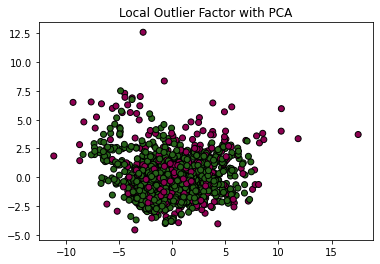

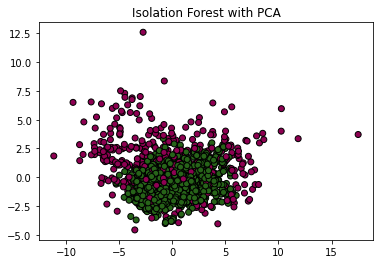

In [96]:
#Unsupervised Anomaly Detection
#Drop last column, scale data, and perform PCA
numeric_data = encoded_data.select_dtypes(include = 'number')
data = numeric_data.iloc[:, :-1]
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

pca = PCA(n_components=2)
data_reduced_pca = pca.fit_transform(data_scaled)

#Perform Local Outlier Factor and Isolation Forest anomaly detection
lof = LocalOutlierFactor(contamination=0.25) 
lof_l = lof.fit_predict(data_scaled)

isolation_forest = IsolationForest(contamination=0.25)
if_l = isolation_forest.fit_predict(data_scaled)

def plot(data, labels, title):
    plt.figure()
    plt.scatter(data[:, 0], data[:, 1], c=labels, cmap='PiYG', edgecolor='k')
    plt.title(title)
    plt.show()

plot(data_reduced_pca, lof_l, "Local Outlier Factor with PCA")
plot(data_reduced_pca, if_l, "Isolation Forest with PCA")